In [ ]:
# the test cases are prepared 1 to 5
test_num = 3

# please write 0 or 1
ISTD_model = 1
model_name = "ISTD_resnet.pth" if ISTD_model else "ISTD_mine_16.pth"

# please write 0 or 1 up to the MoGe output
is_in_frustum = 1

print(model_name)

ISTD_resnet.pth


In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms.functional as TF
from torchvision.models import resnet34, ResNet34_Weights
import torch.nn as nn
from torch.autograd import Variable
import cv2
from model import *
from torchvision import transforms

## transform for ISTD_resnet.pth
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# model structure for ISTD_resnet.pth
class ResNetUNet(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        self.base_layers = list(base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer2 = self.base_layers[5]
        self.layer3 = self.base_layers[6]
        self.layer4 = self.base_layers[7]

        self.up4 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose2d(64, 64, 2, 2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.out_conv = nn.Conv2d(64, 1, 1)

    @staticmethod
    def crop_to_fit(src, target):
        _, _, h_src, w_src = src.shape
        _, _, h_tgt, w_tgt = target.shape
        crop_h = (h_src - h_tgt) // 2
        crop_w = (w_src - w_tgt) // 2
        return src[:, :, crop_h : (crop_h + h_tgt), crop_w : (crop_w + w_tgt)]

    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        d4 = self.up4(x4)
        x3_cropped = self.crop_to_fit(x3, d4)
        d4 = torch.cat([d4, x3_cropped], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        x2_cropped = self.crop_to_fit(x2, d3)
        d3 = torch.cat([d3, x2_cropped], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        x1_cropped = self.crop_to_fit(x1, d2)
        d2 = torch.cat([d2, x1_cropped], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        x0_cropped = self.crop_to_fit(x0, d1)
        d1 = torch.cat([d1, x0_cropped], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        out = nn.functional.interpolate(
            out, size=x.shape[2:], mode="bilinear", align_corners=False
        )
        return torch.sigmoid(out)


# model structure for my model: ISTD_mine_16.pth
def run_mine(img_path, model_path):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = ResNetUNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Cannot load image: {e}")
        return

    img_tensor = TF.to_tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_mask = model(img_tensor)[0, 0]
        binary_mask = (pred_mask > 0.5).float()
        mask_img = TF.to_pil_image(binary_mask.cpu())

        base, _ = os.path.splitext(img_path)
        mask_save_path = base + "_mask.png"
        mask_img.save(mask_save_path)
        print(f"Saved mask to {mask_save_path}")


def run_ISTD(image_path, model_path):
    device = (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    )

    net = SHADOW().to(device)
    net.load_state_dict(torch.load(model_path, map_location=device))
    net.eval()

    img = Image.open(image_path)
    W, H = img.size

    input_tensor = Variable(transform(img).unsqueeze(0)).to(device)
    output = net(input_tensor)

    output = output.mul(255).byte().cpu().numpy().squeeze(0).transpose((1, 2, 0))
    output = cv2.resize(output, (W, H))

    base, _ = os.path.splitext(image_path)
    mask_save_path = base + "_mask.png"
    cv2.imwrite(mask_save_path, output)
    print(f"Saved mask to {mask_save_path}")


if __name__ == "__main__":
    if ISTD_model:
        run_ISTD(f"moge_outputs/test-{test_num}/image.jpg", f"models/{model_name}")
    else:
        run_mine(f"moge_outputs/test-{test_num}/image.jpg", f"models/{model_name}")

Saved mask to moge_outputs/test-3/image_mask.png


Using device: mps

0: 480x640 7 persons, 7 cars, 3 handbags, 65.1ms
Speed: 3.5ms preprocess, 65.1ms inference, 14.7ms postprocess per image at shape (1, 3, 480, 640)
Largest object centroid: (223, 273)
Second largest object centroid: (35, 270)


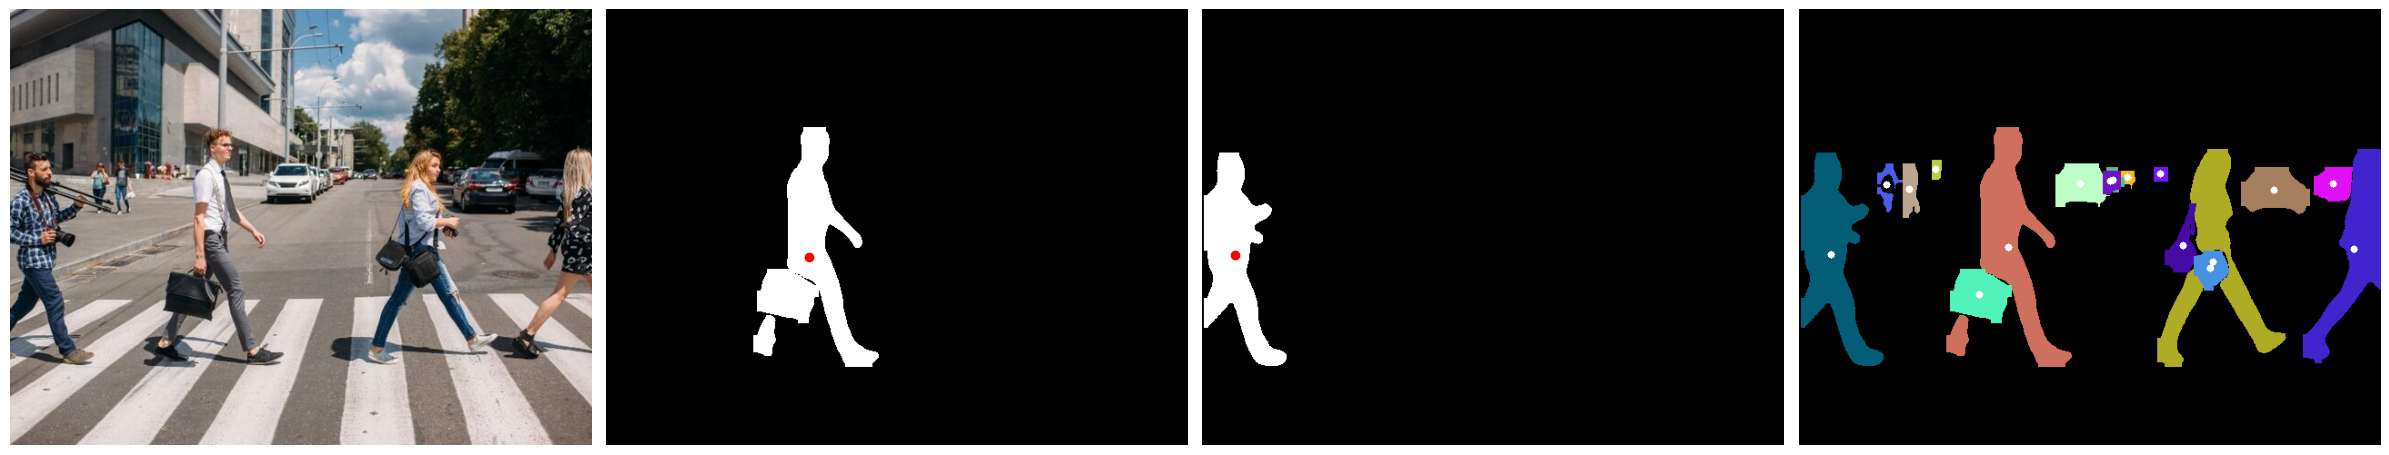

In [ ]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# try to use mps since I have a macbook
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
print(f"Using device: {device}")

model = YOLO("yolov8s-seg.pt").to(device)

# by the selected test number in the beginning, the image is selected
image_path = f"moge_outputs/test-{test_num}/image.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image_rgb.shape[:2]

results = model(image_rgb)[0]

resized_masks = []
areas = []

# find up to the two biggest objects with their relevant ones, which are overlapping, and segment them together
for mask in results.masks.data:
    mask_resized = torch.nn.functional.interpolate(
        mask.unsqueeze(0).unsqueeze(0),
        size=(h, w),
        mode="bilinear",
        align_corners=False,
    )[0, 0]
    binary_mask = (mask_resized > 0.5).cpu().numpy().astype(np.uint8)
    resized_masks.append(binary_mask)
    areas.append(binary_mask.sum())

if not resized_masks:
    raise ValueError("No masks detected.")

sorted_indices = np.argsort(areas)[::-1]
largest_index = sorted_indices[0]
second_index = sorted_indices[1] if len(sorted_indices) > 1 else None

largest_mask = resized_masks[largest_index]
second_mask = resized_masks[second_index] if second_index is not None else None

combined_largest_mask = largest_mask.copy()
for i in sorted_indices[1:]:
    if i == second_index:
        continue
    if np.logical_and(resized_masks[i], largest_mask).sum() > 0:
        combined_largest_mask = np.logical_or(combined_largest_mask, resized_masks[i])

combined_second_mask = None
if second_mask is not None:
    combined_second_mask = second_mask.copy()
    for i in sorted_indices:
        if i in (largest_index, second_index):
            continue
        if np.logical_and(second_mask, resized_masks[i]).sum() > 0:
            combined_second_mask = np.logical_or(combined_second_mask, resized_masks[i])


def compute_centroid(mask):
    ys, xs = np.where(mask == 1)
    if len(xs) == 0 or len(ys) == 0:
        return None
    return int(xs.mean()), int(ys.mean())


centroid_largest = compute_centroid(combined_largest_mask)
centroid_second = (
    compute_centroid(combined_second_mask) if combined_second_mask is not None else None
)

print(
    f"Largest object centroid: {centroid_largest}"
    if centroid_largest
    else "No valid largest object."
)
print(
    f"Second largest object centroid: {centroid_second}"
    if centroid_second
    else "No valid second object."
)

masked_largest = np.zeros_like(image_rgb)
masked_second = np.zeros_like(image_rgb)
if combined_largest_mask is not None:
    masked_largest[combined_largest_mask == 1] = 255
if combined_second_mask is not None:
    masked_second[combined_second_mask == 1] = 255

# detect all objects
masked_all = np.zeros_like(image_rgb)
for mask in resized_masks:
    colour = np.random.randint(0, 256, size=3)
    for c in range(3):
        masked_all[:, :, c][mask == 1] = colour[c]

# draw the centroid
for mask in resized_masks:
    centroid = compute_centroid(mask)
    if centroid:
        cv2.circle(masked_all, centroid, 4, (255, 255, 255), -1)

# plot the result
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].imshow(image_rgb)
axs[0].axis("off")

axs[1].imshow(masked_largest)
axs[1].axis("off")
if centroid_largest:
    axs[1].plot(centroid_largest[0], centroid_largest[1], "ro")

axs[2].imshow(masked_second)
axs[2].axis("off")
if centroid_second:
    axs[2].plot(centroid_second[0], centroid_second[1], "ro")

axs[3].imshow(masked_all)
axs[3].axis("off")

plt.tight_layout()
plt.show()

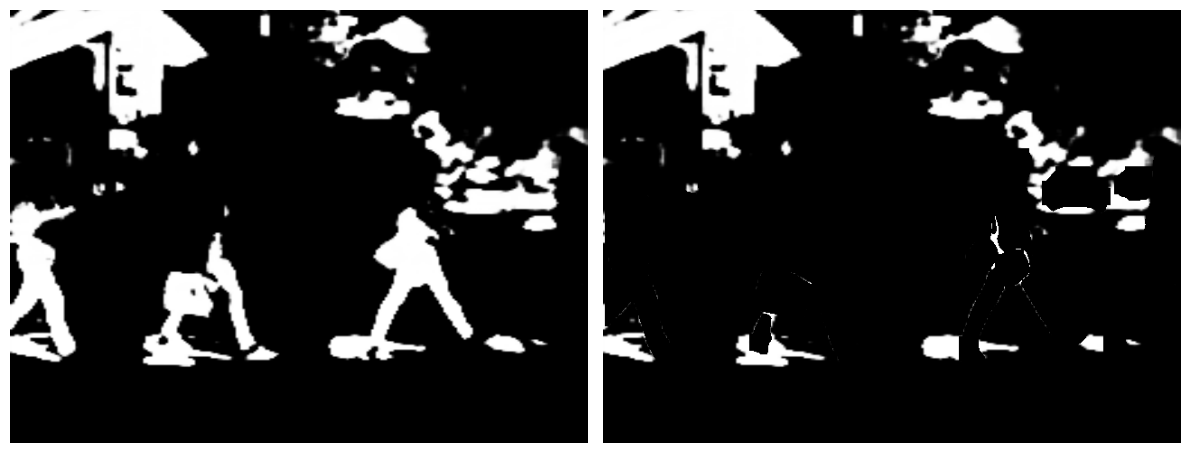

In [ ]:
new_image = cv2.imread(f"moge_outputs/test-{test_num}/image_mask.png")
new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

# combine all detected objects
combined_all_mask = np.zeros((h, w), dtype=np.uint8)
for mask in resized_masks:
    combined_all_mask = np.logical_or(combined_all_mask, mask)

# subtract objects from the shadow mask image
new_image_masked_all = new_image_rgb.copy()
new_image_masked_all[combined_all_mask == 1] = 0

# plot the result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(new_image_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(new_image_masked_all)
plt.axis("off")

plt.tight_layout()
plt.show()

Cluster 0: BBox (0, 0) to (217, 164)
Cluster 0: BBox centroid (blue): (108, 82)
Cluster 0: High-density centroid (red): (110, 62)
Cluster 1: BBox (330, 0) to (464, 63)
Cluster 1: BBox centroid (blue): (397, 31)
Cluster 1: High-density centroid (red): (384, 10)
Cluster 2: BBox (360, 67) to (454, 132)
Cluster 2: BBox centroid (blue): (407, 99)
Cluster 2: High-density centroid (red): (402, 67)
Cluster 3: BBox (447, 112) to (532, 204)
Cluster 3: BBox centroid (blue): (489, 158)
Cluster 3: High-density centroid (red): (472, 117)
Cluster 4: BBox (552, 146) to (605, 194)
Cluster 4: BBox centroid (blue): (578, 170)
Cluster 4: High-density centroid (red): (591, 146)
Cluster 5: BBox (557, 194) to (605, 245)
Cluster 5: BBox centroid (blue): (581, 219)
Cluster 5: High-density centroid (red): (563, 194)
Cluster 6: BBox (0, 340) to (56, 389)
Cluster 6: BBox centroid (blue): (28, 364)
Cluster 6: High-density centroid (red): (0, 340)
Cluster 7: BBox (353, 360) to (393, 387)
Cluster 7: BBox centroid (b

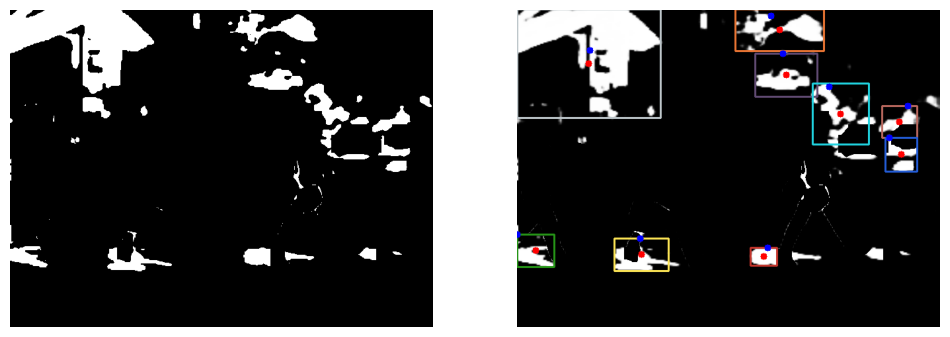

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import scipy.spatial

image = cv2.cvtColor(new_image_masked_all, cv2.COLOR_RGB2GRAY)

_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
binary_image = 255 - binary_image

y, x = np.where(binary_image == 255)
coordinates = np.column_stack((x, y))

# run the DBSCAN cluster algorithm to find where the shadows are
dbscan = DBSCAN(eps=24, min_samples=680)
labels = dbscan.fit_predict(coordinates)

image_with_clusters = new_image_masked_all.copy()


def random_colour():
    return tuple(np.random.randint(0, 256, size=3).tolist())


boxes_centroids = []
radius = 88

for label in np.unique(labels):
    if label == -1:
        continue

    cluster_points = coordinates[labels == label]
    x_min, x_max = np.min(cluster_points[:, 0]), np.max(cluster_points[:, 0])
    y_min, y_max = np.min(cluster_points[:, 1]), np.max(cluster_points[:, 1])

    bbox_centroid = ((x_min + x_max) // 2, (y_min + y_max) // 2)

    kdtree = scipy.spatial.cKDTree(cluster_points)
    density_counts = kdtree.query_ball_point(cluster_points, radius, return_length=True)
    high_density_centroid = tuple(cluster_points[np.argmax(density_counts)])

    colour = tuple(map(int, random_colour()))

    cv2.rectangle(image_with_clusters, (x_min, y_min), (x_max, y_max), colour, 2)
    cv2.circle(image_with_clusters, bbox_centroid, 5, (255, 0, 0), thickness=-1)
    cv2.circle(image_with_clusters, high_density_centroid, 5, (0, 0, 255), thickness=-1)

    boxes_centroids.append(
        {
            "bbox": (x_min, y_min, x_max, y_max),
            "centroid": bbox_centroid,
            "density": high_density_centroid,
            "label": label,
        }
    )

    print(f"Cluster {label}: BBox ({x_min}, {y_min}) to ({x_max}, {y_max})")
    print(f"Cluster {label}: BBox centroid (blue): {bbox_centroid}")
    print(f"Cluster {label}: High-density centroid (red): {high_density_centroid}")

num_clusters = sum(np.sum(labels == l) >= 680 for l in np.unique(labels) if l != -1)
print("Number of clusters:", num_clusters)

# plot the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image_with_clusters)
plt.axis("off")
plt.show()

In [ ]:
import numpy as np
import cv2


def reconstruct_3d_centroid(centroid_2d, depth_map):
    x, y = centroid_2d
    z = float(depth_map[y, x])

    return (x, y, z)


# this euclidean distance function is for 3d coordinates
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))


# get depth for the euclidean distance in 3d
depth_map = cv2.imread(
    f"moge_outputs/test-{test_num}/depth_vis.png", cv2.IMREAD_UNCHANGED
)

if depth_map.ndim == 3:
    depth_single = depth_map[:, :, 0].astype(np.float32)
else:
    depth_single = depth_map.astype(np.float32)

if depth_map.dtype == np.uint8:
    depth_single /= 255.0
elif depth_map.dtype == np.uint16:
    depth_single /= 1000.0

W, H = depth_single.shape[1], depth_single.shape[0]

target_centroids = []
if "centroid_largest" in locals() and centroid_largest is not None:
    target_centroids.append(
        ("largest", reconstruct_3d_centroid(centroid_largest, depth_single))
    )

if "centroid_second" in locals() and centroid_second is not None:
    target_centroids.append(
        ("second", reconstruct_3d_centroid(centroid_second, depth_single))
    )


print(target_centroids)


valid_boxes = []
for i, b in enumerate(boxes_centroids):
    if b is None or "centroid" not in b or b["centroid"] is None:
        print(f"No boxes_centroids[{i}]")
        continue

    valid_boxes.append(b)

nearest_clusters = []

for name, target in target_centroids:
    distances = []
    reconstructed_boxes = []

    for b in valid_boxes:
        centroid_3d = reconstruct_3d_centroid(b["centroid"], depth_single)
        dist = euclidean_distance(target, centroid_3d)
        distances.append(dist)
        reconstructed_boxes.append(centroid_3d)

    if not distances or all(d == np.inf for d in distances):
        print(f"No valid clusters found for centroid {name}")
        continue

    nearest_index = np.argmin(distances)
    nearest_box_centroid = valid_boxes[nearest_index]
    centroid_3d = reconstructed_boxes[nearest_index]

    nearest_clusters.append(
        {
            "name": name,
            "label": nearest_box_centroid["label"],
            "bbox": nearest_box_centroid["bbox"],
            "centroid": centroid_3d,
            "density": nearest_box_centroid["density"],
            "distance": distances[nearest_index],
        }
    )

[('largest', (223, 273, 0.3490196168422699)), ('second', (35, 270, 0.3607843220233917))]


In [ ]:
import json
import numpy as np

# Load FOV
with open(f"moge_outputs/test-{test_num}/fov.json", "r") as f:
    data = json.load(f)

fov_x = data["fov_x"]
fov_y = data["fov_y"]

# since there is no given focal length, put 50 as default of Blender
f_mm = 50

# compute focal length to pixel units
fx = f_mm * W / fov_x
fy = f_mm * H / fov_y
cx, cy = W / 2, H / 2


def adjust_depth(depth, is_in_frustum):
    factor = 0.44 if is_in_frustum else 1.48
    return depth + (1 - depth) * factor


def pixel_to_camera(u, v, depth, fx, fy, cx, cy):
    X = (u - cx) * depth / fx
    Y = (v - cy) * depth / fy
    Z = depth
    return np.array([X, Y, Z])


point_pairs = []

for target in target_centroids:
    name, target_point = target
    match = next((c for c in nearest_clusters if c["name"] == name), None)
    if match is None:
        continue

    x1, y1_raw, z1_raw = match["centroid"]
    x2, y2_raw, z2_raw = target_point

    y1 = H - y1_raw
    y2 = H - y2_raw

    z1 = adjust_depth(z1_raw, is_in_frustum)
    z2 = adjust_depth(z2_raw, is_in_frustum)

    point1 = pixel_to_camera(x1, y1, z1, fx, fy, cx, cy)
    point2 = pixel_to_camera(x2, y2, z2, fx, fy, cx, cy)

    point1_vec = f"Vector(({point1[0]:.4f}, {point1[2]:.4f}, {point1[1]:.4f}))"
    point2_vec = f"Vector(({point2[0]:.4f}, {point2[2]:.4f}, {point2[1]:.4f}))"

    point_pairs.append(f"({point1_vec}, {point2_vec})")

# print out the result of mapped object and shadow coordinates as pairs
# the output is copied to the Blender file: blender_results.blend
print(f'parent_object_name = "test-{test_num}"')
print(f"color_flag = {ISTD_model}")
print("point_pairs = [")
for pair in point_pairs:
    print(pair + ",")
print("]")

parent_object_name = "test-3"
color_flag = 1
point_pairs = [
    (Vector((-0.0953, 0.7035, -0.0958)), Vector((-0.0633, 0.6355, -0.0220))),
    (Vector((-0.2175, 0.7255, -0.0943)), Vector((-0.1879, 0.6420, -0.0202))),
]
